In [135]:
import numpy as np
import pandas as pd
import os
import datetime
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
# ============================================================
# Unified Snow_in_NOLA Preprocessing Notebook
# ============================================================
# This notebook combines the preprocessing pipelines written by:
#   - Caleb
#   - Bipin
#   - Mehedi

# ============================================================

# --- Step 1: Upload CSV File ---

import pandas as pd
import numpy as np
import io
import os
from glob import glob

data_directory = "MSY Weather Data Files"

# Input a directory, process each year, concat at the end

desired_columns = ['DATE', 'SOURCE', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature',
                   'HourlyDryBulbTemperature', 'HourlyPrecipitation',
                   'HourlyPresentWeatherType', 'HourlyRelativeHumidity',
                   'HourlySkyConditions', 'HourlySeaLevelPressure',
                   'HourlyStationPressure', 'HourlyVisibility',
                   'HourlyWetBulbTemperature', 'HourlyWindDirection',
                   'HourlyWindGustSpeed', 'HourlyWindSpeed']


# ============================================================
# Step 2: Caleb’s Preprocessing Code
# ============================================================

def caleb_preprocess(df):

    # --- Separate Date and Time ---
    df['Date'] = pd.to_datetime(df['DATE'], errors='coerce').dt.date
    df['TIME'] = pd.to_datetime(df['DATE'], errors='coerce').dt.time
    df['Time'] = df['TIME'].astype('string')

    # --- Drop unwanted rows ---
    df = df[df['Time'] != '23:59:00']  # Daily Averages
    df = df[df['SOURCE'] != 9]  # Semi-hourly check-in, not real measurements

    # --- Visibility & Temperature interpolation ---
    for col in ['HourlyVisibility', 'HourlyWetBulbTemperature']:
        df[col] = pd.to_numeric(df[col], errors='coerce').interpolate(
            method='linear').ffill()

    # --- Wind Direction broken up into NWSE components ---
    avg_wind_dir = pd.to_numeric(
        df['HourlyWindDirection'], errors='coerce').mean()
    df['HourlyWindDirection'] = df['HourlyWindDirection'].replace(
        'VRB', avg_wind_dir).fillna(0).astype(int)
    df['HourlyWindSpeed'] = pd.to_numeric(
        df['HourlyWindSpeed'], errors='coerce').fillna(0)

    df['HourlyWindEastWest'] = df['HourlyWindSpeed'] * \
        np.sin(np.radians(df['HourlyWindDirection']))
    df['HourlyWindNorthSouth'] = df['HourlyWindSpeed'] * \
        np.cos(np.radians(df['HourlyWindDirection']))

    df['HourlyWindEast'] = np.where(
        df['HourlyWindEastWest'] > 0, df['HourlyWindEastWest'], 0)
    df['HourlyWindWest'] = np.where(
        df['HourlyWindEastWest'] < 0, abs(df['HourlyWindEastWest']), 0)
    df['HourlyWindNorth'] = np.where(
        df['HourlyWindNorthSouth'] > 0, df['HourlyWindNorthSouth'], 0)
    df['HourlyWindSouth'] = np.where(
        df['HourlyWindNorthSouth'] < 0, abs(df['HourlyWindNorthSouth']), 0)

    for col in ['HourlyWindNorth', 'HourlyWindSouth', 'HourlyWindEast', 'HourlyWindWest', 'HourlyWindGustSpeed']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # --- Drop irrelevant columns ---
    df = df.drop(['Date', 'TIME', 'Time', 'SOURCE', 'HourlyWindDirection',
                  'HourlyWindSpeed', 'HourlyWindEastWest', 'HourlyWindNorthSouth'], axis=1, errors='ignore')

    print("Caleb preprocessing complete.")
    return df

# ============================================================
# Step 3: Bipin’s Preprocessing Code
# ============================================================


def bipin_preprocess(df):

    # --- Weather Type Cleaning ---
    snow_codes = ['SN', 'SG', 'PL', 'IC', 'PE',
                  'RASN', 'SHSN', 'FZRA', 'FZDZ', 'BLSN', 'DRSN']

    def clean_weather_type(x):
        if pd.isna(x):
            return 0
        for code in snow_codes:
            if code in str(x):
                return 1
        return 0
    df["HourlyPresentWeatherType"] = df["HourlyPresentWeatherType"].apply(
        clean_weather_type)

    # --- Sky Condition Cleaning ---
    sky_map = {'CLR': 0, 'FEW': 1, 'SCT': 2,
               'BKN': 3, 'OVC': 4, '10': 5, 'VV': 6}

    def sky_to_numeric(s):
        if pd.isna(s):
            return 0
        parts = [sky_map[k] for k in sky_map.keys() if k in str(s)]
        return max(parts) if parts else 0
    df["HourlySkyConditions"] = df["HourlySkyConditions"].apply(sky_to_numeric)

    # --- Pressure Cleaning ---
    for col in ["HourlySeaLevelPressure", "HourlyStationPressure"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        ffill = df[col].ffill()
        bfill = df[col].bfill()
        df[col] = df[col].fillna((ffill + bfill) / 2).ffill()

    df = df.dropna(subset=["HourlyRelativeHumidity"], how="any")
    for col in ["HourlyRelativeHumidity"]:
        df[col] = pd.to_numeric(df[col], errors='coerce').interpolate(
            method='linear').ffill()

    print("Bipin preprocessing complete.")
    return df

# ============================================================
# Step 4: Mehedi's Preprocessing Code
# ============================================================


def third_preprocess(df):

    scale_columns = [
        'HourlyAltimeterSetting',
        'HourlyDewPointTemperature',
        'HourlyDryBulbTemperature',
        'HourlyPrecipitation'
    ]

    if 'SOURCE' in df.columns:
        df['SOURCE'] = pd.to_numeric(df['SOURCE'], errors='coerce')
        df = df[df['SOURCE'] != 9]

    # --- Fill missing ---
    for col in scale_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].interpolate(
                method='linear', limit_direction='both')

    print("Mehedi's preprocessing complete.")
    return df

# Change date and time


def encode_datetime_features(df):
    if 'date_only' in df.columns and 'time_only' in df.columns:
        df['DATE'] = pd.to_datetime(df['date_only'].astype(
            str) + ' ' + df['time_only'].astype(str), errors='coerce')
    elif 'DATE' in df.columns:
        df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

    df = df.dropna(subset=['DATE']).copy()
    df['year'] = df['DATE'].dt.year
    df['hour'] = df['DATE'].dt.hour
    df['minute'] = df['DATE'].dt.minute
    df['day_of_year'] = df['DATE'].dt.dayofyear

    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_the_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_the_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    df = df.drop(columns=['DATE', 'date_only',
                 'time_only', 'Time'], errors='ignore')
    print(" Date/time successfully encoded into numeric + cyclical features.")
    return df

# ============================================================
# Step 5: Combined
# ============================================================


print("Combined ")


def preprocess(directory_path):
    clean_data_list = []

    files_list = os.listdir(directory_path)
    files_list.sort()

    for filename in files_list:
        filepath = os.path.join(directory_path, filename)
        df = pd.read_csv(filepath, low_memory=False, usecols=desired_columns)

        df_clean = caleb_preprocess(df)  # Start with the original df
        df_clean = bipin_preprocess(df_clean)
        df_clean = third_preprocess(df_clean)
        df_clean = encode_datetime_features(df_clean)

        clean_data_list.append(df_clean)

    total_clean_data = pd.concat(clean_data_list, ignore_index=True)

    return total_clean_data


output_processed_data = preprocess(data_directory)

print(
    f"Final cleaned dataset has {output_processed_data.shape[0]} rows and {output_processed_data.shape[1]} columns.")
display(output_processed_data[11765:11780])

# ============================================================
# Step 6: Download Cleaned CSV
# ============================================================

output_filename = "Clean_Snow_in_NOLA.csv"
output_path = output_filename
output_processed_data.to_csv(output_path, index=False)
print(f"Cleaned file: {output_filename}")

In [139]:
# Instead, we are gonna use a LSTM

class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, sigma=0.01, lr=0.01):
        super().__init__()
        self.save_hyperparameters()

        # Define fn to initialize weights
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)

        def triple(): return (init_weight(num_inputs, num_hiddens),
                              init_weight(num_hiddens, num_hiddens),
                              nn.Parameter(torch.zeros(num_hiddens)))

        # LSTM parameters
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate params
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate params
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate params
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node params

        # Initialize output parameters too (transform hidden state to usable output)
        self.W_hq = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b_q = nn.Parameter(torch.zeros(num_outputs))

        # Loss function
        # Cross entropy is a typical RNN/LSTM loss choice
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, inputs, H_C=None):
        # inputs: (Batch_size, Time_step, Dimensions)
        batch_size, seq_len, _ = inputs.shape

        # Start Hidden State and Memory Cell as 0
        if H_C is None:
            # Initialize hidden state as 0
            H = torch.zeros((batch_size, self.num_hiddens),
                            device=inputs.device)
            C = torch.zeros((batch_size, self.num_hiddens),
                            device=inputs.device)  # Initialize memory as 0
        else:
            H, C = H_C

        # Within the batch, iterate over time steps
        for t in range(seq_len-1):  # X has (seq_len - 1) time steps
            X = inputs[:, t, :]  # shape: (Batch_Size, Dimensions)

            # 0-1 functions provide the "fraction" to keep/forget. [-1, +1] allows for reduction of memory cell values
            # Input gate: How much of H_(t-1) to remember
            I = torch.sigmoid(X @ self.W_xi + H @ self.W_hi + self.b_i)
            # Forget gate: How much of H_(t-1) to forget
            F = torch.sigmoid(X @ self.W_xf + H @ self.W_hf + self.b_f)
            # Output gate: Helps create new H_t
            O = torch.sigmoid(X @ self.W_xo + H @ self.W_ho + self.b_o)
            # Input node: Influence memory cell with H_(t-1)
            C_tilde = torch.tanh(X @ self.W_xc + H @ self.W_hc + self.b_c)

            C = F * C + I * C_tilde  # New memory cell, element-wise operation
            H = O * torch.tanh(C)  # New hidden state

        # calc the output value from the final hidden state of the batch
        out_value = H @ self.W_hq + self.b_q
        out = out_value.float()  # make it a float for the loss function

        return out  # return final output

    def loss(self, y_hat, y):
        # Reshaping allows for output of dimensions (Batch_size, 1 [final t_step], 26 [num_features])
        # loss_fn def as cross entropy before
        return self.loss_fn(y_hat.reshape(-1, y_hat.shape[-1]), y.reshape(-1, y.shape[-1]))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [140]:
# go from pandas df to numpy array (easier for torch tensors)
numpy_output = output_processed_data.to_numpy()
# save scaling values for unscaling later
scale_values = np.max(numpy_output, axis=0)
opd = numpy_output/scale_values  # normalize
opdl = opd.shape[0]  # total length of data

train_sample = opd[0:int(0.7*(opdl))]  # 70% training
validation_sample = opd[int(0.7*(opdl)):int(0.9*(opdl))]  # 20% val
test_sample = opd[int(0.9*(opdl)):]  # 10% test

In [141]:
# Need sequences
def create_sequences(X, seq_len):
    """
    Splits the input data into sequential groups. The examples are (seq_len - 1) hours and the label is the following last hour.
    """
    X_seqs, Y_seqs = [], []
    for i in range(len(X) - seq_len + 1):
        X_seqs.append(torch.Tensor(X[i:i+seq_len-1]))  # seq_len hours as input
        # save next hour as true output
        Y_seqs.append(torch.Tensor(X[i+seq_len-1:i+seq_len]))

    # go from list of tensors to stacked tensors
    X_seqs = torch.stack(X_seqs).float()
    Y_seqs = torch.stack(Y_seqs).float()
    return X_seqs, Y_seqs  # return the tensor stacks


seq_len = 168  # take last week of data to predict the next hour. 7 * 24 = 168
X_train_seq, Y_train_seq = create_sequences(train_sample, seq_len)
X_val_seq,   Y_val_seq = create_sequences(validation_sample, seq_len)
X_test_seq,  Y_test_seq = create_sequences(test_sample, seq_len)

In [142]:
# Put the data in a form that d2l likes for the DataLoader
train_dataset = TensorDataset(X_train_seq, Y_train_seq)
val_dataset = TensorDataset(X_val_seq,   Y_val_seq)
test_dataset = TensorDataset(X_test_seq,  Y_test_seq)

In [143]:
# Batches are groups of sequences
batch_size = 64

# Wrap the data in a module so d2l likes it even more


class MyDataModule(d2l.DataModule):
    def __init__(self, batch_size, train_dataset, val_dataset):
        super().__init__()
        self.save_hyperparameters()
        self.train = train_dataset
        self.val = val_dataset

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

    def get_dataloader(self, train):
        dataset = self.train_dataset if train else self.val_dataset
        # allowed to shuffle because sequences preserve temporal relationships
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=train)

In [144]:
data_module = MyDataModule(batch_size, train_dataset, val_dataset)
model = LSTMScratch(num_inputs=train_dataset.tensors[0].shape[2],
                    num_hiddens=64, num_outputs=train_dataset.tensors[1].shape[2], lr=0.0001)
# num inputs = num columns (26), num outputs = num columns also. We want to predict the entire next vector to generate new data

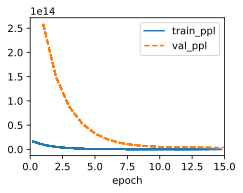

In [145]:
# Do the actual training, generate loss plots

trainer = d2l.Trainer(max_epochs=15, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data_module)

In [149]:
# Predict values for 2025
# Use last known sequence from dataset
last_known_sequence, true_last_output = test_dataset[len(
    test_dataset)-1]  # retrieve last known data sequence
threshold = 0.4

# Storage for predictions
predictions_2025 = {
    "hour_index": [],
    "snow_prediction": [],
    "high_temperature": [],
    "low_temperature": [],
    "precipitation_prediction": []
}

# Predict the next year of weather data
hours_2025 = 365 * 24

for hour in range(hours_2025):

    # Predict the next hour
    next_row = model(last_known_sequence.reshape(1, seq_len-1, 26)).detach()

    # Extract Snow, Precipitation, Temp and from the predicted features
    pred_precip = float(next_row[0][3].item())
    pred_snow_raw = next_row[0][4].item()
    pred_temp = float(next_row[0][2].item())

    # Convert raw weather-type prediction to binary snow
    pred_snow = 1 if pred_snow_raw > threshold else 0

    # Store predictions
    predictions_2025["hour_index"].append(hour)
    predictions_2025["snow_prediction"].append(pred_snow)
    predictions_2025["high_temperature"].append(pred_temp)
    predictions_2025["low_temperature"].append(pred_temp)
    predictions_2025["precipitation_prediction"].append(pred_precip)

    # Create next seq_len window (drop earliest hour, add predicted new hour)
    last_known_sequence = torch.cat(
        (last_known_sequence[1:], next_row),
        dim=0
    )

# Unnormalize the data
predictions_2025["high_temperature"] = np.array(
    predictions_2025["high_temperature"])*scale_values[2]
predictions_2025["low_temperature"] = np.array(
    predictions_2025["low_temperature"])*scale_values[2]
predictions_2025["precipitation_prediction"] = np.array(
    predictions_2025["precipitation_prediction"])*scale_values[3]

# Convert to DataFrame
df_pred_2025 = pd.DataFrame(predictions_2025)

first_three_days = df_pred_2025[0:(24*3)]
first_three_days = first_three_days.drop(["low_temperature"], axis=1)
first_three_days.rename(
    columns={"high_temperature": "temperature"}, inplace=True)

# Aggregate into daily Snow/Precipitation summaries
daily = df_pred_2025.groupby(df_pred_2025["hour_index"] // 24).agg({
    "snow_prediction": "max",          # if any hour snows, the day snows
    "high_temperature": "max",
    "low_temperature": "min",
    "precipitation_prediction": "sum"  # total daily precipitation
}).reset_index()

# go from hours to days now that we have grouped to days as the time unit
daily.rename(columns={"hour_index": "day_of_year"}, inplace=True)

daily['day_of_year'] = pd.to_datetime('2025-01-01') + pd.to_timedelta(
    daily['day_of_year'], unit='D')  # go from 'day 0' to '2025-01-01'

In [ ]:
first_three_days.to_csv('first_three_days.csv')
daily.to_csv('daily.csv')